In [1]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 57 kB 1.5 MB/s eta 0:00:011
     |████████████████████████████████| 547 kB 7.2 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import transforms, datasets, models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import seaborn as sns
from copy import deepcopy, copy
from PIL import Image
from os import listdir
from torchvision.transforms import Compose, ToPILImage, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np
import json


from livelossplot import PlotLosses
from pycm import *

In [4]:
'''
HYPER-PARAMETERS
'''
seed = 42
lr = 1e-2
mom = 0.9
batch_size = 64
test_batch_size = 100
n_epochs = 10
img_mean, img_std = (0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821);
img_size = 224

In [5]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True
set_seed(seed)
device = 'cuda' if (torch.cuda.device_count() > 0 and torch.cuda.is_available()) else 'cpu'
print(device)

cuda


In [6]:
transform_train = Compose([
    # transforms.ToPILImage(),
    transforms.Resize(224),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    ToTensor(),
    Normalize(img_mean, img_std),
])
transform_test = Compose([
    ToTensor(),
    Normalize(img_mean, img_std),
])

In [8]:
path = '/kaggle/input/miniproject'
imagenet = datasets.ImageFolder(root=F'/kaggle/input/miniproject/train', transform=transform_train)
imagenet_transforms = Compose([ToTensor(), Normalize(img_mean, img_std)])

In [10]:
#imagenet[0]

In [32]:
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
train_size = int(0.7*len(imagenet))
test_size = len(imagenet) - train_size

imagenet_train, imagenet_val = random_split(imagenet, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
        imagenet_train, batch_size=batch_size,
        num_workers=0
    )

valid_loader = torch.utils.data.DataLoader(
        imagenet_val, batch_size=batch_size,
        num_workers=0
    )

In [17]:
def train(model, optimizer, criterion, data_loader):
    '''
    Trains input model and calculates training loss and accuracy in return.
    '''
    model.train() # set to training-mode to access the training behaviour of model
    train_loss, train_accuracy = 0., 0. # Initialize rolling sum of loss and accuracies
    for X, y in data_loader:            # Iterate over every batch (B) of X (B, C, H, W) and Y 
      X, y = X.to(device), y.to(device) # Send to device (cuda)
      optimizer.zero_grad()             # Reset gradients
      # ! Batch size set to -1 as this will make PyTorch work out what the remainder should be
      # ! LeNet5 base class overwrites __call__() to run forward when it's accessed like this
    
      a2 = model(X.view(-1, 3, img_size, img_size).float()) # Run forward model
      loss = criterion(a2, y)           # Calculate BCE Loss
      #print("loss",loss)
      loss.backward()                   # Backpropagate error associated with batch
      train_loss += loss*X.size(0)      # Accumulate loss over batch
      y_pred = F.log_softmax(a2, dim=1).max(1)[1]   # Make predictions based on highest softmax output
      # Accumulate accuracy over batch.                 ... Detach y_pred from computational graph
      train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
      #print("loss",loss)
      optimizer.step()                  # Take a (stochastic) gradient descent step 
    # Return training loss and accuracies normalized by the dataset size
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    '''
    Calculate performance metrics without running any optimizations.
    '''
    model.eval()  # Set to evaluation mode to avoid learning procedures in model
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:                  # Iterate over every batch (B) of X (B, C, H, W) and Y 
        with torch.no_grad():                 # Deactivate the autograd routine
            #X = transforms.functional.to_pil_image(X)
            X, y = X.to(device), y.to(device) # Send to device (cuda)
            a2 = model(X.view(-1, 3, img_size, img_size).float()) # Run forward model
            loss = criterion(a2, y)           # Calculate BCE Loss
            validation_loss += loss*X.size(0) # Accumulate loss over batch
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # Make predictions based on highest softmax output
            # Accumulate accuracy over batch.
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
    # Return training loss and accuracies normalized by the dataset size
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    '''
    Calculate performance metrics without running any optimizations.
    '''
    model.eval()  # Set to evaluation mode to avoid learning procedures in model
    ys, y_preds = [], []  # Keep track of what predictions and labels
    for X, y in data_loader:                  # Iterate over every batch (B) of X (B, C, H, W) and Y 
        with torch.no_grad():                 # Deactivate the autograd routine
            X, y = X.to(device), y.to(device) # Send to device (cuda)
            a2 = model(X.view(-1, 3, img_size, img_size).float()) # Run forward model
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # Make predictions based on highest softmax output
            ys.append(y.cpu().numpy())                  # Get actual class and append to ground truth list
            y_preds.append(y_pred.cpu().numpy())        # Append to predictions list
    # Return predictions and ground truths list
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [13]:
import torchvision.models as models
model_res18 = models.resnet18(pretrained=True)

#for param in model_den201.parameters():
#    param.requires_grad = False

model_res18.fc=nn.Linear(in_features=512,out_features=200,bias=True)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [15]:
#model_res18

# 19:39 begin 52 16

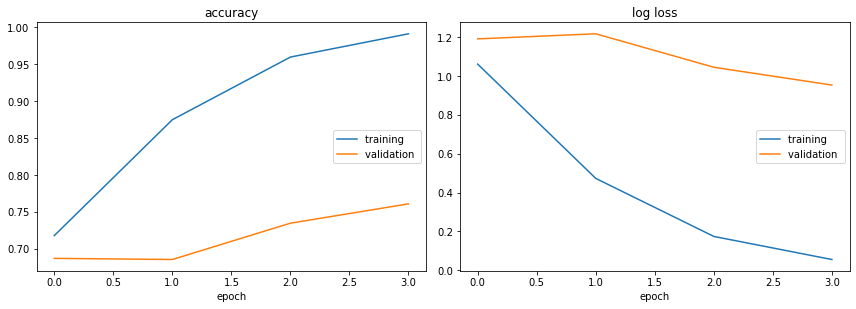

accuracy
	training         	 (min:    0.480, max:    0.991, cur:    0.991)
	validation       	 (min:    0.057, max:    0.761, cur:    0.761)
log loss
	training         	 (min:    0.056, max:    1.699, cur:    0.056)
	validation       	 (min:    0.173, max:    1.216, cur:    0.953)


In [ ]:
set_seed(seed)
model = model_res18.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=mom)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(10):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, valid_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    model_save_name = 'Res18_'+str(epoch)+'_classifier.pt'
    torch.save(model.state_dict(), F"/kaggle/working/" + model_save_name)

    liveloss.update(logs)
    liveloss.draw()